In [1]:
import pandas as pd
import numpy as np
import data
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, HMC
import matplotlib.pyplot as plt

pyro.set_rng_seed(0)

/home/mjbajwa/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mjbajwa/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
def load_data():

    # Load Data

    df = pd.read_table("./data/rdata", header=None, delim_whitespace=True)
    df.columns = ["X", "Y"]
    df["index"] = np.where(df.index < 100, "Train", "Test")

    # Create train and test

    X_train = np.array(df.loc[df["index"] == "Train", "X"]).reshape(-1, 1)
    Y_train = np.array(df.loc[df["index"] == "Train", "Y"])
    X_test = np.array(df.loc[df["index"] == "Test", "X"]).reshape(-1, 1)
    Y_test = np.array(df.loc[df["index"] == "Test", "Y"])

    return X_train, X_test, Y_train, Y_test

In [3]:
X_train, X_test, Y_train, Y_test = load_data()

In [4]:
def bnn_forward(x, w_ih, b_h, w_ho, b_o):
    
    z1 = torch.mm(x, w_ih) + b_h
    a1 = torch.tanh(z1)
    output = torch.mm(a1, w_ho) + b_o
    
    return output

In [6]:
def model(x):
    
    # Hyperparameters
    
    w_ih_prec = pyro.sample("w_ih_prec", dist.Gamma(0.025, 0.000625))
    b_h_prec = pyro.sample("b_h_prec", dist.Gamma(0.025, 0.000625))
    w_ho_prec = pyro.sample("w_ho_prec", dist.Gamma(0.025, 0.000625))
    y_prec = pyro.sample("y_prec", dist.Normal(0.025, 0.000625))
    
    # Low Level Parameters

    w_ih = pyro.sample("w_ih", dist.Normal(loc=torch.zeros((1, 8)), scale=1/torch.sqrt(w_ih_prec)))
    b_h = pyro.sample("b_h", dist.Normal(loc=torch.zeros((1, 8)), scale=1/torch.sqrt(b_h_prec)))
    w_ho = pyro.sample("w_ho", dist.Normal(loc=torch.zeros((8, 1)), scale=1/torch.sqrt(w_ho_prec)*1/np.sqrt(8)))
    b_o = pyro.sample("b_o", dist.Normal(loc=torch.zeros((1, 1)), scale=100))
    
    # Forward Pass

    z1 = torch.mm(x, w_ih) + b_h
    a1 = torch.tanh(z1)
    output = torch.mm(a1, w_ho) + b_o
    
    return pyro.sample("y_pred", dist.Normal(output, 1/torch.sqrt(y_prec)))


def conditioned_model(model, x, y):
    return poutine.condition(model, data={"y_pred": y})(x)

In [ ]:
nuts_kernel = NUTS(conditioned_model, jit_compile=True)
hmc_kernel = HMC(conditioned_model, jit_compile=True, num_steps=1024)

mcmc = MCMC(hmc_kernel,
            num_samples=20000,
            warmup_steps=500,
            num_chains=1)

mcmc.run(model, 
         torch.tensor(X_train).float(), 
         torch.tensor(Y_train).float())

mcmc.summary()

Warmup:   0%|          | 0/20500 [00:00, ?it/s]/home/mjbajwa/anaconda3/lib/python3.6/site-packages/torch/autograd/__init__.py:225: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  inputs, allow_unused, accumulate_grad=False)
/home/mjbajwa/anaconda3/lib/python3.6/site-packages/torch/distributions/utils.py:38: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  fo

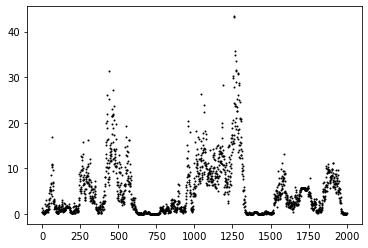

In [27]:
samples = mcmc.get_samples()
plt.plot(1/torch.sqrt(samples["w_ho_prec"]), "ko", markersize=1)

In [ ]:
plt.plot(samples["w_ih_prec"], "ko", markersize=2)